# 폐렴 판별기
폐렴인지 아닌지 구별하기 위한 것으로 실력 좋은 의사가 90프로 이상의 판별 능력을 가지고 있다고 한다.  
이미지가 큰편이라 줄이지 않고 모델을 학습시키면 좋지만 메모리의 문제등 낮춰서 진행한다.  
기본 모델의 정확도가 80프로 정도로 85프로까지 목표로 잡았다.

## 아이디어
불균형(imbalance) 데이터 처리  
- 최근에 Outlier Detection을 위한 모델을 보았다. 그것을 사용해 이상 데이터가 부족하더라도 찾을 수 있도록 해볼 것이다.
  


In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from PIL import Image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [256, 256]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj26/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1076
Pneumonia images count in training set: 3109


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [7]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

Image shape:  (256, 256, 3)
Label:  True
624


In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label



In [11]:
# 
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


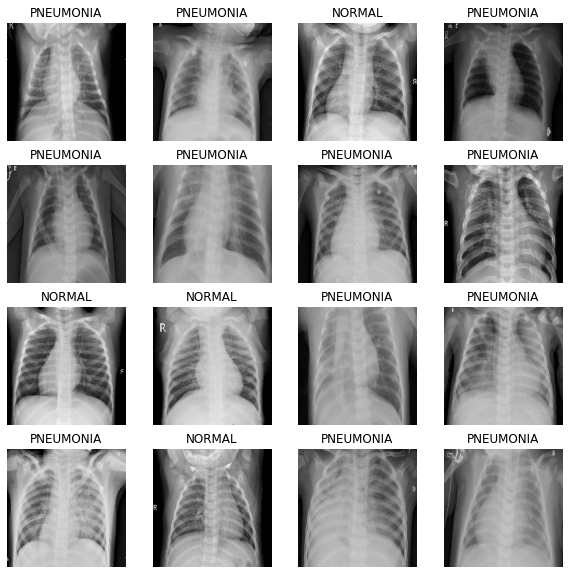

In [26]:
image_batch, label_batch = next(iter(train_ds))
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 모델 구성 

In [12]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model



### imbalance 문제 기본해결

In [14]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [15]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [16]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 200s 744ms/step - loss: 0.4054 - accuracy: 0.7989 - precision: 0.9600 - recall: 0.7643 - val_loss: 0.6535 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 192s 735ms/step - loss: 0.2558 - accuracy: 0.8989 - precision: 0.9706 - recall: 0.8924 - val_loss: 1.3177 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 192s 737ms/step - loss: 0.2341 - accuracy: 0.9138 - precision: 0.9745 - recall: 0.9081 - val_loss: 0.2241 - val_accuracy: 0.9077 - val_precision: 0.9985 - val_recall: 0.8768
Epoch 4/25
261/261 [==============================] - 192s 738ms/step - loss: 0.1889 - accuracy: 0.9293 - precision: 0.9809 - recall: 0.9223 - val_loss: 0.1633 - val_accuracy: 0.9308 - val_precision: 0.9225 - val_recall: 0.9896
Epoch 5/25
261/261 [==============================] - 192s 737ms/step - loss: 0.1753 - a

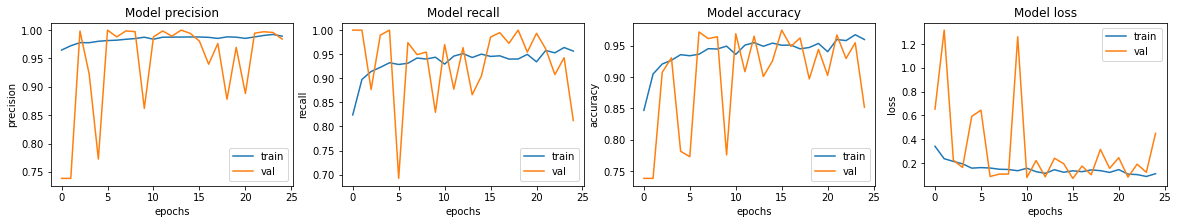

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 160ms/step - loss: 0.4276 - accuracy: 0.8526 - precision: 0.8565 - recall: 0.9179


### 기본 모델의 개선후 목표인 85프로 달성
단순히 일부 사진 좌우 반전으로 목표치를 달성하였다. 하지만 매번 에폭당 validation의 정확도 및 로스가 미쳐날 뛰어 사실 다시 돌리면 내가 원한 값이 나올지 의문이 드는 결과다.

## Outlier Detection 모델용


In [22]:
IMAGE_SIZE = [128, 128]
def process_path_1(file_path):
    imgs = []    
    for i in file_path:
        img = tf.io.read_file(i)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, IMAGE_SIZE)
        imgs.append(img)
    return np.array(imgs)
a = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/NORMAL/*'))
a =process_path_1(a)


In [28]:
val = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/NORMAL/*'))
val =  process_path_1(val)

In [45]:
from alibi_detect.models import resnet
mod_te = resnet(3,classes= 1,input_shape=(256,256,3))


In [46]:
mod_te.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 258, 258, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 16) 432         conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 16) 64          conv1[0][0]                      
_____________________________________________________________________________________________

In [23]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(128, 128, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(256, 4, strides=2, padding='same', activation=tf.nn.relu),
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(8 * 8 * 128),
    Reshape(target_shape=(8, 8, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.005,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [13]:
decoder_net.summary()
encoder_net.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 16, 16, 256)       524544    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 32, 32, 64)        262208    
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 64, 64, 32)        32800     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 128, 128, 3)       1539      
Total params: 9,217,891
Trainable params: 9,217,891
Non-trainable params: 0
____________________________________________

In [34]:
with tf.device('/GPU:0'):
    history = od.fit(a,epochs = 5, verbose = True)

21/21 [=] - 30s 1s/step - loss: -34310.6896


In [60]:
idx = 12
x = a[idx].reshape(1, 128, 128, 3)
x_recon = od.vae(x).numpy()


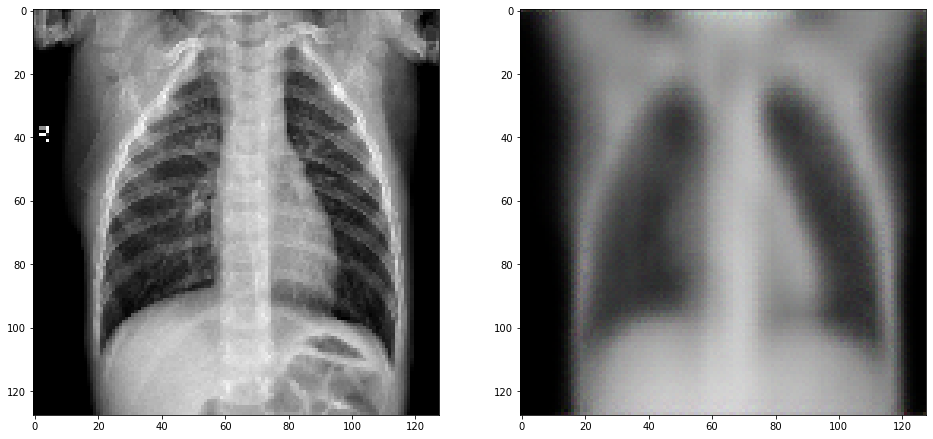

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

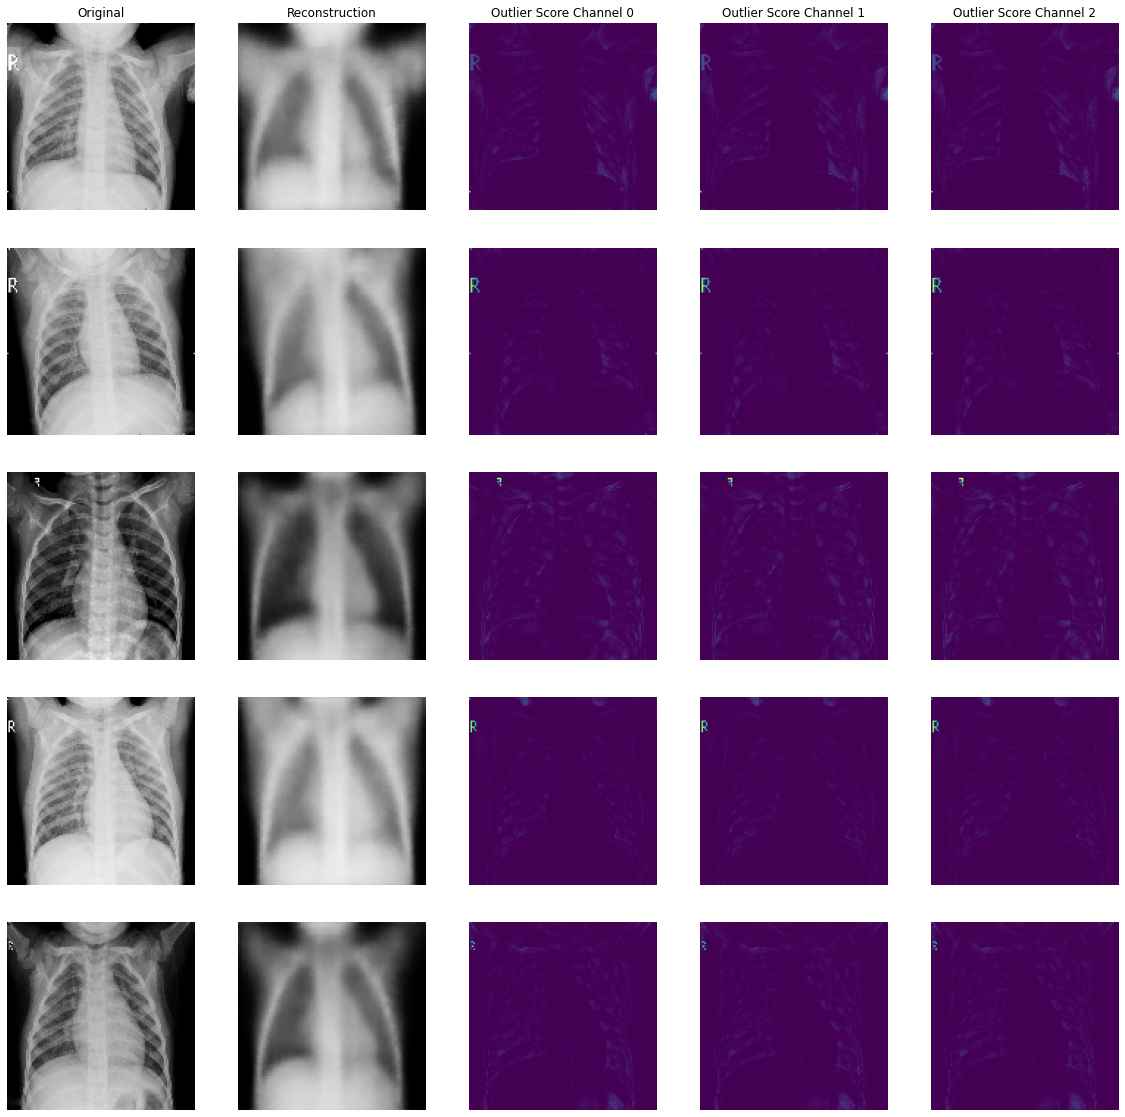

In [35]:
od_preds = od.predict(val,outlier_type='instance',return_feature_score=True,return_instance_score=True)

x_recon = od.vae(val).numpy()

plot_feature_outlier_image(
    od_preds,
    val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

In [37]:
test_od = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/PNEUMONIA/*'))
test_od =  process_path_1(test_od)
od_preds = od.predict(test_od,outlier_type='instance',return_feature_score=True,return_instance_score=True)



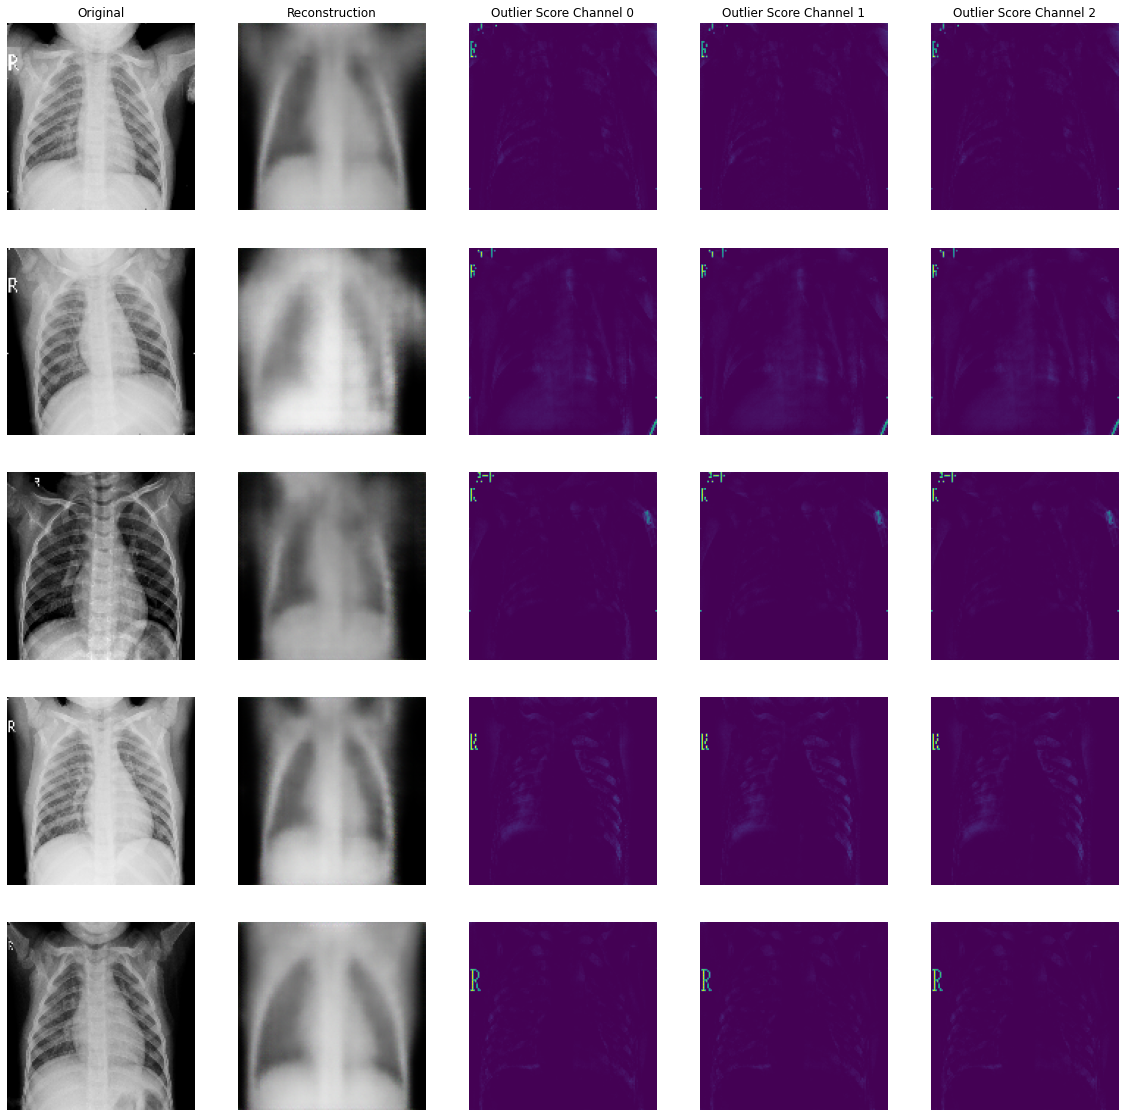

In [39]:
x_recon = od.vae(test_od).numpy()


plot_feature_outlier_image(
    od_preds,
    val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only= True
)

## alibi outlier 모델 고찰
이미 기본 모델에서 85프로를 달성하였기에 새로운 모델을 맛만 보기 위해 사용하였다.  
목적은 어느정도 성능을 발휘 할 것 같은지 확인 하는 것이었다.  
일단은 목적은 달성하였다. 이 모델은 간단히 하면 정상사진들을 재구성하는것을 학습한다.  
기본에 재구성한 사진을 빼면(간단히 설명) 이상치들이 나오고 그것을 기준(treshold)과 비교하여 이상한지 판별하는 것이다. 


### 정상사진의 스코어

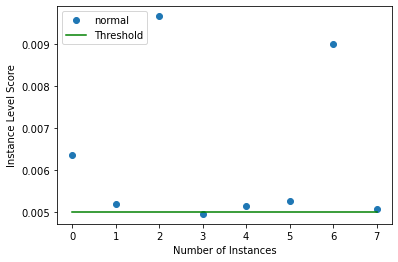

In [36]:
target = np.zeros(val.shape[0],).astype(int)
labels = ['normal']
plot_instance_score(od_preds, target, labels, od.threshold)

### 이상치(폐렴)의 스코어 

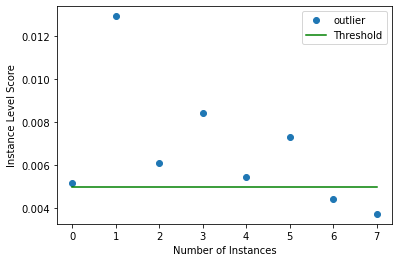

In [40]:
target = np.zeros(test_od.shape[0],).astype(int)
labels = ['outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

정상사진과 이상치의 것을 비교하면 